## Introduction to Logistic Regression from scratch

Logistic regression is a discriminative classification technique for binary classification problems. It's commonly used the baseline model for binary classification problem.

In essence, logistic regression is similar linear regression; only difference is that the results are passed through a **Sigmoid activation function** to convert continuous outputs into probabilities. These probabilities are then turned into actual classed based on a **threshold value**.

### Assumptions of Logistic Regression

As mentioned above, logistic regression is a slight twisk from linear regression. As a result, key assumptions hold the same. 

* Little to no multicollinearity among independent variables.
* Data points are independent.

### Math behind Logistic Regression
Given a training set of $N$ samples, $D=\lbrace (x_1, y_1), ..., (x_N, y_N)\rbrace$, where $x_i$ is a multidimensional input vector with dimension $P$ and class label (target or response).

For each class, the classifier seek for a vector of parameters $w$ that performs a linear combination of the input variables, $x^Tw$. This step performs a **projection** or a **rotation** of input sample into a good discriminative one-dimensional sub-space, that best discriminate sample of current class vs sample of other classes.

Logistic regression uses logistic function to frame binary output model.

<img src="pic/fig1.png" width = 200>

The output of the logistic regression is transformed by a **Sigmoid Function** into a **probability** ($0≤x≤1$), and can be used to predict the binary 0 or 1 depending on the threshold value chosen.

---
## Logistic Regression from Scratch

Now let's implement logistic regression from scratch. The model will be built based on gradient descent techniques, and built solely on numpy.

In [119]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
# import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [54]:
class LogisticRegresssionManual:
    """
    Implement Logistic Regression with Gradient Descent from scratch
    """
    
    def __init__(self, learning_rate = 0.001, n_iters = 1000, threshold = 0.5):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.threshold = threshold

    def _sigmoid(self, x):
        """
        Pass results from the fit method into sigmoid function.
        
        Parameters
        --------
        x: array, predicted probabilities
        """
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        """
        Peform iterative gradient descent
        
        Parameters
        --------
        X: array, features
        y: array, ground truth label
        """
        n_samples, n_features = X.shape
        
        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # gradient descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_pred = self._sigmoid(linear_model)
            
            # compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.bias * db
    
    def predict_proba(self, X):
        """
        Make probability predictions using sigmoid function.
        
        Parameters
        --------
        X: array, predicted probabilities
        """
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(linear_model)
        return y_pred
    
    def predict(self, X):
        """
        Make class predictions using sigmoid function. 
        
        Parameters
        --------
        X: array, features
        """
        y_pred = self.predict_proba(X)
        y_pred_cls = [1 if i > self.threshold else 0 for i in y_pred]
        return np.array(y_pred_cls)

In [63]:
bc = load_breast_cancer() ## Binary Classification Problem
X, y = bc.data, bc.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 91)

In [91]:
%%time

regressor = LogisticRegression(solver='liblinear')
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

print("SKLearn accuracy:", accuracy_score(y_test, predictions))
print("SKLearn confusion metric:")
print(confusion_matrix(y_test, predictions))

SKLearn accuracy: 0.956140350877193
SKLearn confusion metric:
[[45  3]
 [ 2 64]]
CPU times: user 9.02 ms, sys: 2.12 ms, total: 11.1 ms
Wall time: 10.4 ms


In [101]:
%%time

regressor = LogisticRegresssionManual(learning_rate=0.0001, n_iters=5000, threshold=0.5)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

print("Manual accuracy:", accuracy_score(y_test, predictions))
print("Manual confusion metric:")
print(confusion_matrix(y_test, predictions))

Manual accuracy: 0.8947368421052632
Manual confusion metric:
[[44  4]
 [ 8 58]]
CPU times: user 304 ms, sys: 24.9 ms, total: 328 ms
Wall time: 193 ms


### Solvers in Sklearn

From the results above, we can see there are two stunning facts.
* Sklearn-optimized logistic regression **performs better** than manual logistic regression without tuning parameters.
* Sklearn-optimized model **performs 30x faster** than the manual-built one.

The key here is that sklearn-optimized logistic regression uses other solver instead of gradient descent. Below are some key notes on different solvers.

1. **Newton**: twisted Gradient Descent with first AND second partial derivatives (The Hessian matrix) -> **quadratic approximation**
    * It’s **computationally expensive** because of The Hessian Matrix.
    * It attracts to **Saddle Points** which are common in multivariable optimization.
---
2. **Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm (lbfgs)**: analogue of the Newton’s Method but here **the Hessian matrix is approximated** using updates specified by gradient evaluations
    * When dataset is **small**, lbfgs relatively **performs the best** compared to other methods
    * If it is unsafeguarded, it may **not converge to anything**.

---
3. **A Library for Large Linear Classification (LIBLINEAR)**: coordinate descent (CD) algorithm that solves optimization problems by successively performing approximate minimization along coordinate directions or coordinate hyperplanes
    * Recommended when you have high **dimension dataset**
    * Get stuck at a non-stationary point (i.e. non-optima) if the level curves of a function are not smooth.
    * Cannot learn a true multinomial (multiclass) model 
    
### Sensitivity analysis on threshold
Another key factor to discuss here is the **threshold value**. The default threshold for logistic regression model is 0.5. However, for most of the binary classification task, this default value is by no means the best one. To perform custom threshold value, we need to use the `predict_proba` function and conduct sensitivity analysis to see what the best threshold value is.



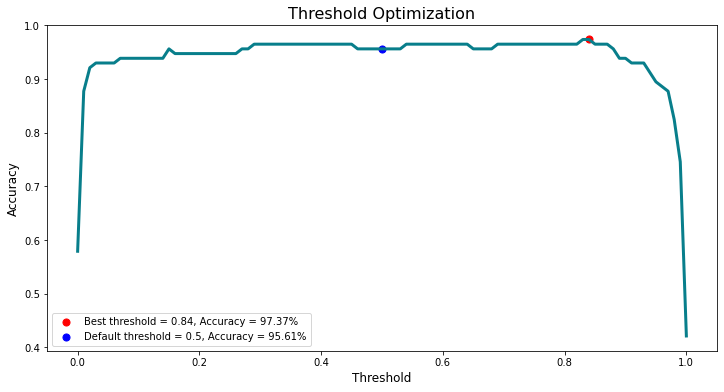

In [149]:
def _run_sensitivity_analysis(X_train, y_train, X_test, y_test):
    """
    Run sensitivity analysis on the threshold value
    
    Parameters
    --------
    X_train: training feature
    y_train: training ground truth label
    X_test: testing feature
    y_test: testing ground truth label
    """
    regressor = LogisticRegression(solver='liblinear')
    regressor.fit(X_train, y_train)
    prob = regressor.predict_proba(X_test)

    evals = []
    for thres in np.arange(0, 1.01, 0.01):
        preds = [1 if p > thres else 0 for p in pd.DataFrame(prob)[1]]
        acc = accuracy_score(y_test, preds)
        evals.append({'Threshold': thres, 'Accuracy': acc})
    
    return evals

def plot_threshold_analysis(X_train, y_train, X_test, y_test):
    """
    Run threshold analysis and plot out the result.
    
    """
    evals = pd.DataFrame(_run_sensitivity_analysis(X_train, y_train, X_test, y_test))

    best_thres = evals.sort_values(by='Accuracy', ascending=False).iloc[0]
    default_thres = evals.iloc[50]

    plt.figure(figsize=(12,6))
    plt.plot(evals['Threshold'], evals['Accuracy'], lw=3, c='#087E8B')
    plt.scatter(best_thres['Threshold'], best_thres['Accuracy'], label=f"Best threshold = {best_thres['Threshold']}, Accuracy = {(best_thres['Accuracy'] * 100):.2f}%", s=50, c='r')
    plt.scatter(default_thres['Threshold'], default_thres['Accuracy'], label=f"Default threshold = {default_thres['Threshold']}, Accuracy = {(default_thres['Accuracy'] * 100):.2f}%", s=50, c='b')
    plt.title('Threshold Optimization', size=16)
    plt.xlabel('Threshold', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.legend()
    plt.show()

plot_threshold_analysis(X_train, y_train, X_test, y_test)

From the plot above, we can see that the best threshold in this **breast cancer classification dataset** is 0.84, with accuracy approaching 97.5%. Without tuning this threshold value, we can only achieve an accuracy around 95.6%.

---
### Final Topics

Below are some of the topics related to logistic regression worth mentioning.

#### Logit Function Explained

The logit function can be written as:

$$\log(\frac{p(X)}{1-p(X)}) = \beta_0 + \beta_1X$$

The left-hand side is called *log-odds* or *logit*. Increasing $X$ by one unit changes the log odds by $\beta_1$, or equivalently mmultiplies the odds by $e^{\beta_1}$.


#### Log Odd Explained

Log odds is best explained through probability concepts. Probability of an event is a measure of the likelihood of that event.

- Odds can be formulated as $p(X)/[1-p(X)]$. **The higher the value of odds, the more likely the event is to occur**.
- Odds can take on **any value between $0$ and $\infty$. Values of the odds close to 0 and $\infty$ indicate very low and very high probabilities of default, respectively**.

<img src="pic/fig2.png" width = 200>

---
### Reference

[Logistic Regression in Python - Machine Learning From Scratch](https://www.youtube.com/watch?v=JDU3AzH3WKg&list=PLqnslRFeH2Upcrywf-u2etjdxxkL8nl7E)

[Logistic regression python solvers' definitions](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)

[Master Machine Learning: Logistic Regression From Scratch With Python](https://towardsdatascience.com/master-machine-learning-logistic-regression-from-scratch-with-python-acfe73a0a424)